In [ ]:
# RAG Implementation
# RAG Workflow to converse with a PDF Document
# 1. Chunking documents
# 2. Store/Embed into Vector Database
# 3. Prompt Definition
# 4. Build retrieval chain for LLM

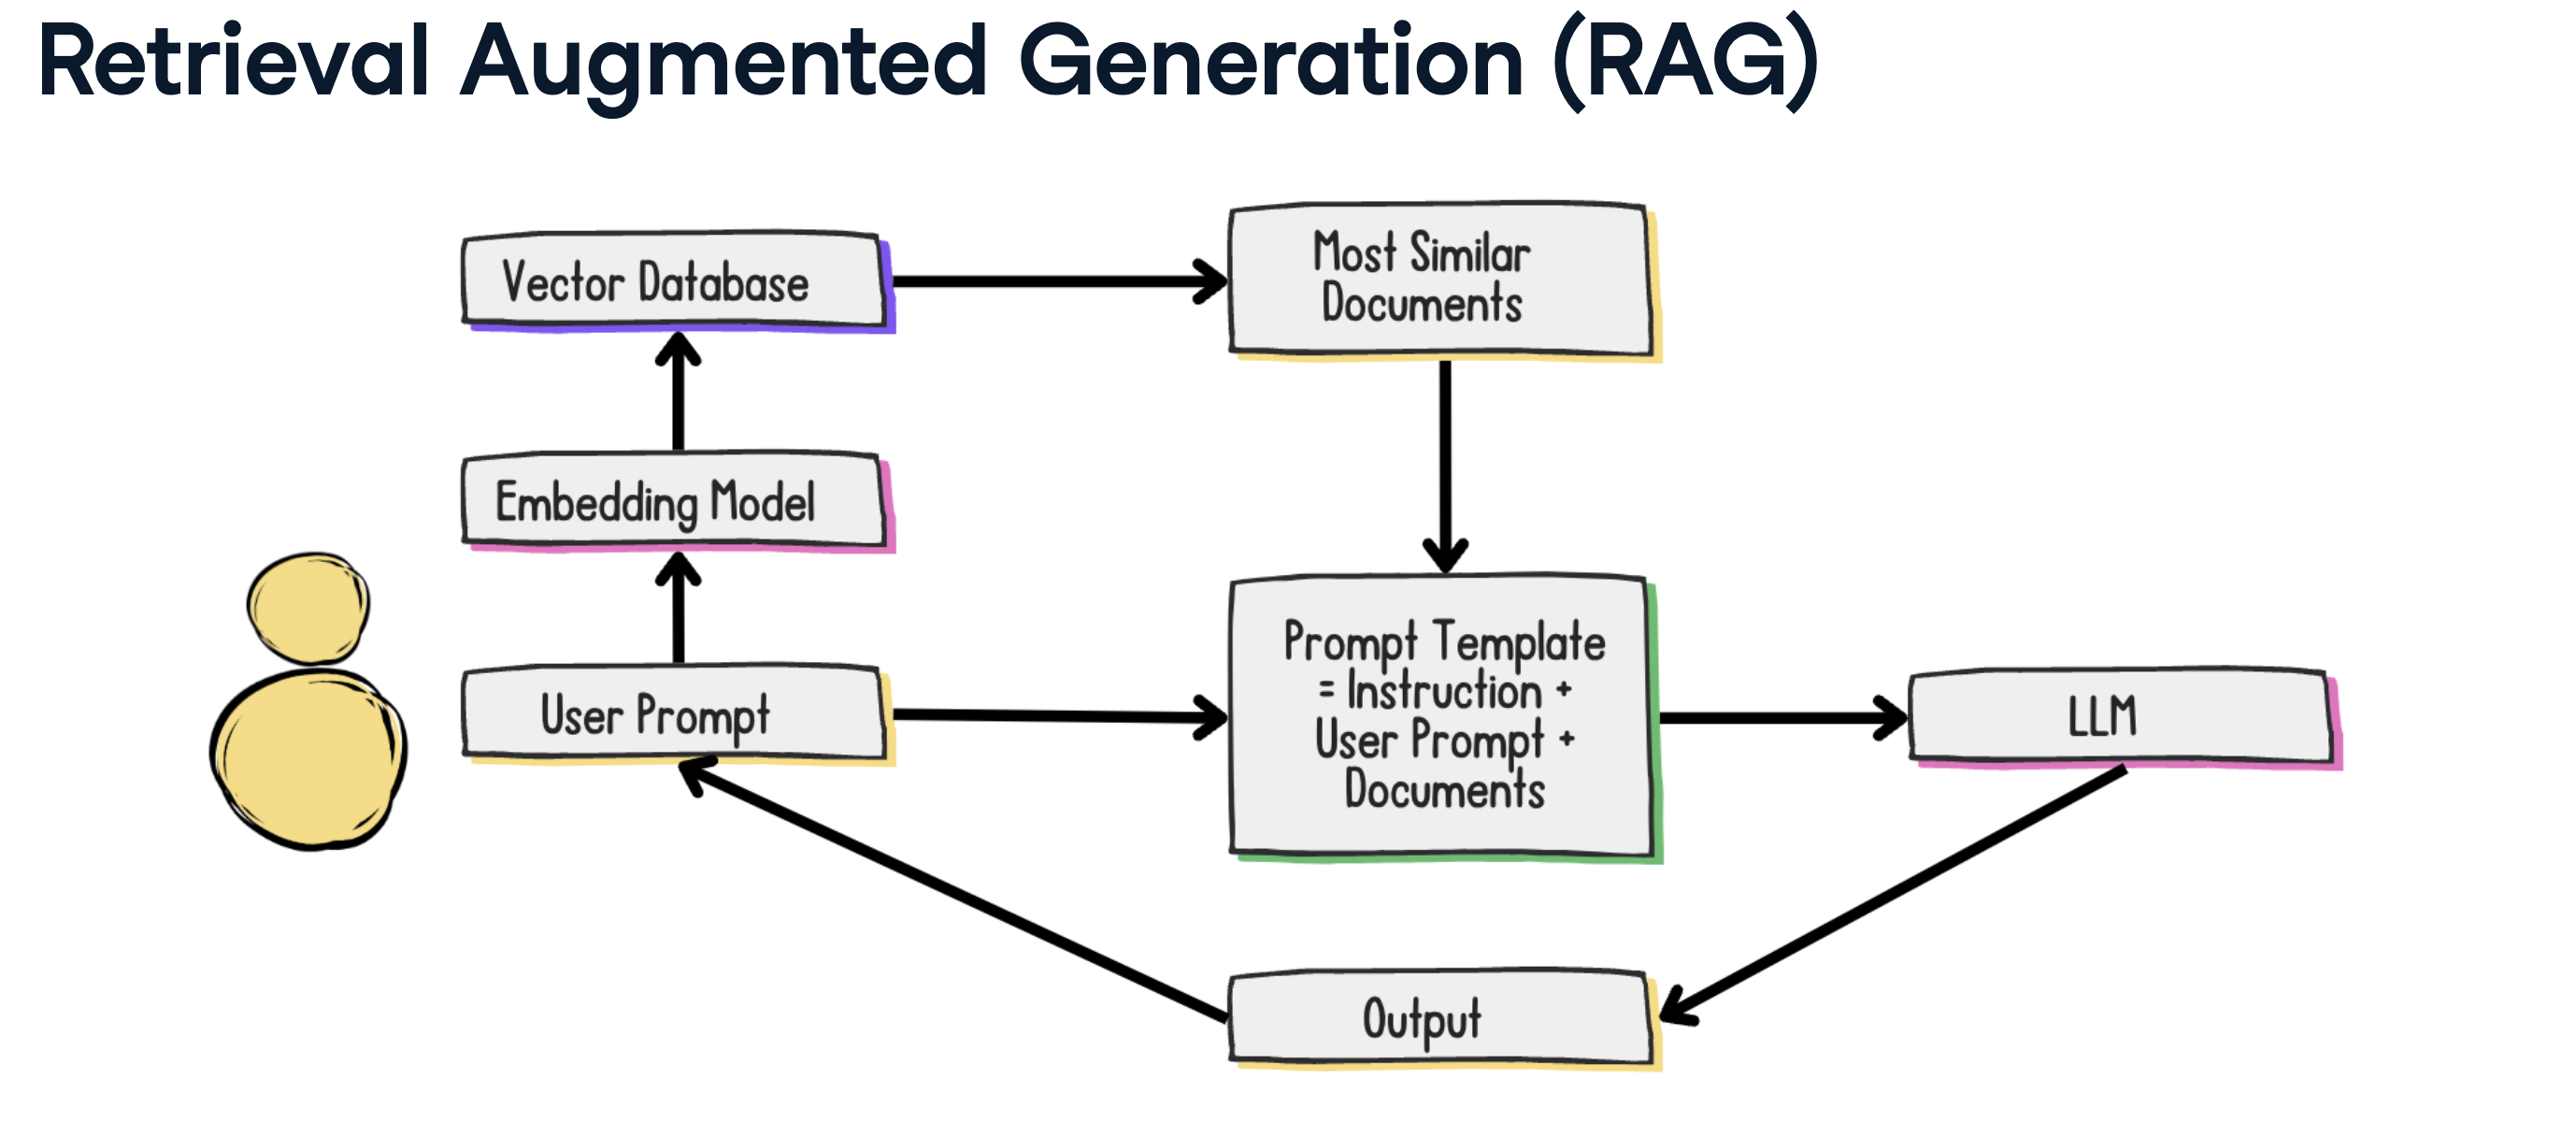

In [7]:
# !pip install langchain
# !pip install pypdf
# !pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.6 MB/s eta 0:00:00


In [8]:
# import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

Document Loaders:
1. PDF
2. CSV
3. HTML

In [13]:
# Import library
from langchain.document_loaders import PyPDFLoader
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders import UnstructuredHTMLLoader

# Rag Paper PDF
# Create a document loader for rag_vs_fine_tuning.pdf
loader = PyPDFLoader('rag_vs_fine_tuning.pdf')
# Load the document
data = loader.load()
# print(data[0])

# Fifa Dataset
# Create a document loader for fifa_countries_audience.csv
loader = CSVLoader('fifa_countries_audience.csv')
# Load the document
data = loader.load()
print(data[0])

# White House Executive Data
# Create a document loader for unstructured HTML
loader = UnstructuredHTMLLoader('white_house_executive_order_nov_2023.html')

# Load the document
data = loader.load()

# Print the first document
print(data[0])

# Print the first document's metadata
print(data[0].metadata)

page_content='country: United States
confederation: CONCACAF
population_share: 4.5
tv_audience_share: 4.3
gdp_weighted_share: 11.3' metadata={'source': 'fifa_countries_audience.csv', 'row': 0}


In [ ]:
# Create a document loader for unstructured HTML
loader = UnstructuredHTMLLoader('white_house_executive_order_nov_2023.html')

# Load the document
data = loader.load()

# Print the first document
print(data[0])

# Print the first document's metadata
print(data[0].metadata)

Character Text Splitter:
1. Character Splitting
2. Recursive Character Splitting
3. HTML Splitting


In [ ]:
# Import the character splitter
from langchain.text_splitter import CharacterTextSplitter

quote = 'Words are flowing out like endless rain into a paper cup,\nthey slither while they pass,\nthey slip away across the universe.'
chunk_size = 24
chunk_overlap = 10

# Create an instance of the splitter class
splitter = CharacterTextSplitter(
    separator='\n',
    chunk_size=24,
    chunk_overlap=10
)

# Split the string and print the chunks
docs = splitter.split_text(quote)
print(docs)
print([len(doc) for doc in docs])

In [ ]:
# Import the recursive character splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

quote = 'Words are flowing out like endless rain into a paper cup,\nthey slither while they pass,\nthey slip away across the universe.'
chunk_size = 24
chunk_overlap = 10

# Create an instance of the splitter class
splitter = RecursiveCharacterTextSplitter(
    separators=["\n"," ",""],
    chunk_size=24,
    chunk_overlap=10
)

# Split the document and print the chunks
docs = splitter.split_text(quote)
print(docs)
print([len(doc) for doc in docs])

In [ ]:
# Recursive character splitter for html documents
# Load the HTML document into memory
loader = UnstructuredHTMLLoader('white_house_executive_order_nov_2023.html')
data = loader.load()

# Define variables
chunk_size = 300
chunk_overlap = 100

# Split the HTML
splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=['.'])

docs = splitter.split_documents(data)
print(docs)

In [ ]:
# Actual RAG Workflow

1. Prepare documents and vector database

In [ ]:
# Set your API Key from OpenAI
openai_api_key = ''

loader = PyPDFLoader('/rag_vs_fine_tuning.pdf')
data = loader.load()

# Split the document using RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap=50
)
docs = splitter.split_documents(data)

# Embed the documents in a persistent Chroma vector database
embedding_function = OpenAIEmbeddings(openai_api_key="")
vectorstore = Chroma.from_documents(
    docs,
    embedding=embedding_function,
    persist_directory=os.getcwd()
)

# Configure the vector store as a retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

2. Create prompt template for retrieval

In [ ]:
# Makes this simple to integrate externald data with LLMs in RAG workflows
# Add placeholders to the message string
message = """
Answer the following question using the context provided:

Context:
{context}

Question:
{question}

Answer:
"""

# Create a chat prompt template from the message string
prompt_template = ChatPromptTemplate.from_messages([("human", message)])

In [ ]:
# Set your API Key from OpenAI
openai_api_key = ''

vectorstore = Chroma.from_documents(
    docs,
    embedding=OpenAIEmbeddings(openai_api_key=""),
    persist_directory=os.getcwd()
)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=openai_api_key)

# Create a chain to link retriever, prompt_template, and llm
rag_chain = ({"context": retriever, "question": RunnablePassthrough()}
            | prompt_template
            | llm)

# Invoke the chain
response = rag_chain.invoke("Which popular LLMs were considered in the paper?")
print(response.content)